# Spatial partitioning in Dask-GeoPandas

Dask-GeoPandas has implemented `spatial_shuffle` method to repartition `Dask.GeoDataFrames` geographically.
For those who are not familiar with Dask, a Dask DataFrame is internally split into many partitions, where each partition is a Pandas DataFrame.
Partitions are split vertically along the index; 

<img src="https://docs.dask.org/en/latest/_images/dask-dataframe.svg" alt="drawing" width="300"/>

There are numerous strategies that can be used to partition Dask DataFrames, which determines how the elements of a DataFrame are separated into each resulting partition.
Common strategies to partition Dask DataFrames include using a fixed number of partitions or partitions based on column values.
Dask-GeoPandas partitions GeoDataFrames by taking advantage of their spatial structure.

In the rest of this notebook, we use an example dataset to describe how Dask-GeoPandas takes advantage of this spatial structure and some best practices.

In [1]:
import geopandas
import dask_geopandas
import matplotlib.pyplot as plt

/Users/tstatham/anaconda3/envs/gsoc/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


We first begin by reading USA boundaries from [gadm.org](https://gadm.org/)

In [2]:
path = "https://geodata.ucdavis.edu/gadm/gadm4.0/gpkg/gadm40_USA.gpkg"

In [3]:
usa = geopandas.read_file(path, layer="ADM_1")
usa.head()

,ID_0,COUNTRY,ID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,USA,United States,USA.1_1,Alabama,AL|Ala.,,State,State,,US.AL,,"MULTIPOLYGON (((-88.12063 30.23321, -88.12122 ..."
1,USA,United States,USA.2_1,Alaska,AK|Alaska,,State,State,,US.AK,,"MULTIPOLYGON (((179.20071 51.35992, 179.20010 ..."
2,USA,United States,USA.3_1,Arizona,AZ|Ariz.,,State,State,,US.AZ,,"MULTIPOLYGON (((-110.87869 31.33084, -110.9720..."
3,USA,United States,USA.4_1,Arkansas,AR|Ark.,,State,State,,US.AR,,"MULTIPOLYGON (((-91.90713 33.00801, -92.01710 ..."
4,USA,United States,USA.5_1,California,CA|Calif.,,State,State,,US.CA,,"MULTIPOLYGON (((-117.23300 32.77416, -117.2330..."


In [4]:
# Filter and rename cols
usa = usa[["NAME_1", "geometry"]].rename(columns={"NAME_1": "State"})
usa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   State     51 non-null     object  
 1   geometry  51 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 944.0+ bytes


<AxesSubplot:>

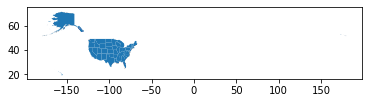

In [5]:
usa.plot()

We can quickly filter for Contiguous United States, which represents the 48 joining states and the District of Columbia (DC) by the `cx` method.
This filters out any geometries using a bounding box.

In [6]:
us_cont = usa.cx[-150:-50, 20:50]
us_cont.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49 entries, 0 to 50
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   State     49 non-null     object  
 1   geometry  49 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 1.1+ KB


<AxesSubplot:>

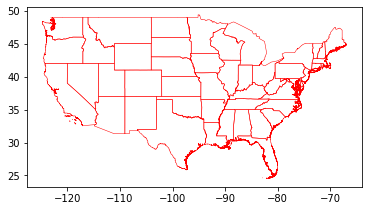

In [7]:
us_cont.plot(facecolor="none", linewidth=0.5, edgecolor="red")

We can then transform the `geopandas.GeoDataFrame` to a `dask_geopandas.GeoDataFrame`, with a fixed number of arbitrary partitions - this does not yet spatially partition a Dask GeoDataFrame.

```{note} 
We can also read (and export) parquet files in Dask-GeoPandas containing spatially partitioned data.
```

In [8]:
d_gdf = dask_geopandas.from_geopandas(us_cont, npartitions=4)
d_gdf

,State,geometry
npartitions=4,,
0,object,geometry
15,...,...
28,...,...
41,...,...
50,...,...


By visualising the convex hull of each partition, we can get a feel for how the Dask-GeoDataFrame has been partitioned using the fixed number.
A useful spatial partitioning scheme is one that minimises the degree of spatial overlap between partitions. 
By default, the fixed number of partitions does a poor job of spatially partitioning our example data - there is a high degree of overlap between partitions.

In [9]:
d_gdf.calculate_spatial_partitions() # convex hull
d_gdf.spatial_partitions

0    POLYGON ((-81.96430 24.52042, -82.87569 24.610...
1    POLYGON ((-89.42000 28.92833, -90.92028 29.048...
2    POLYGON ((-109.04997 31.33190, -114.63287 35.0...
3    POLYGON ((-97.40186 25.83808, -97.40523 25.838...
dtype: geometry

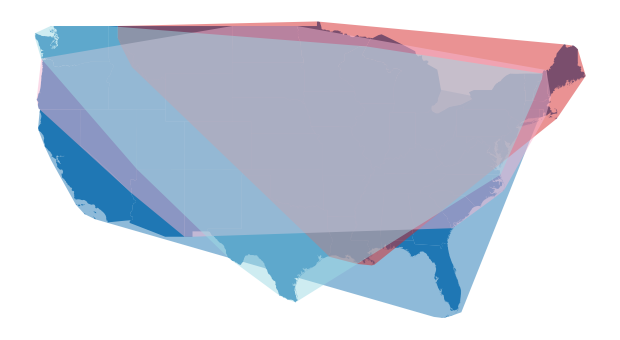

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
us_cont.plot(ax=ax)
d_gdf.spatial_partitions.plot(ax=ax, cmap="tab20", alpha=0.5)
ax.set_axis_off()
plt.show()

Spatial partitioning a Dask GeoDataFrames is done using `spatial_shuffle`, which is based on Dasks `set_index` and spatial sorting.

## Spatial sorting methods
`spatial_shuffle` supports three different partitioning methods, which provide a simple and relatively inexpensive way of representing two-dimensional objects in one-dimensional space.
These are called using the `by` parameter;
1. Hilbert distance (default)
2. Morton distance
3. Geohash

The first two methods are [space-filling curves](https://en.wikipedia.org/wiki/Space-filling_curve), which are lines that pass through every point in space, in a particular order and pass through points once only, so that each point lies a unique distance along the curve.
The range of both curves contain the entire 2-dimensional unit square, which means that the Hilbert and Morton curves can handle projected coordinates.
In general, we recommend the default Hilbert distance because it has better order-preserving behaviour.
This is because the curve holds a remarkable mathematical property, where the distance between two consecutive points along the curve is always equal to one.
By contrast, the Morton distance or ["Z-order curve"](https://en.wikipedia.org/wiki/Z-order_curve) does not hold this property and there are larger "jumps" in distances between two consecutive points.
Currently, calculated distances along the curves are based on the mid points of geometries.
Whilst this is inexpensive, mid points do not represent complex geometries well.
Future work will examine various methods for better representing complex geometries.

The Geohash, not to be confused with [geohashing](https://geohashing.site/geohashing/Main_Page), is a hierarchical spatial data structure, which subdivides space into buckets of grid shape.
Whilst the Geohash does allow binary searchers or spatial indexing, like rtree or quadtree, Geohash is limited to encoding latitude and longitude coordinates.
The Geohash can be represented either as text string or integers, where the longer the string/integer is, the more precise the grid shape 
will be.

Below we compare the different sorting methods using the default parameters.
All 3 sorting methods reduce the degree of spatial overlap but this still remains high and could be further improved by controlling specific parameters.

In [11]:
hilbert = d_gdf.spatial_shuffle(by="hilbert")
morton = d_gdf.spatial_shuffle(by="morton")
geohash = d_gdf.spatial_shuffle(by="geohash")

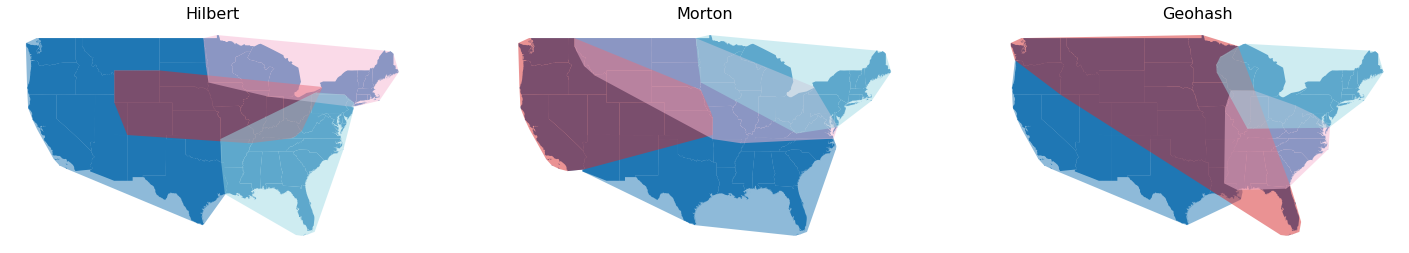

In [12]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(25,12))
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    us_cont.plot(ax=ax)

hilbert.spatial_partitions.plot(ax=ax1, cmap="tab20", alpha=0.5)
morton.spatial_partitions.plot(ax=ax2, cmap="tab20", alpha=0.5)
geohash.spatial_partitions.plot(ax=ax3, cmap="tab20", alpha=0.5)

[axi.set_axis_off() for axi in axes.ravel()]

ax1.set_title("Hilbert", size=16)
ax2.set_title("Morton", size=16)
ax3.set_title("Geohash", size=16)

plt.show()

## Number of partitions
The first parameter is the `npartitions` or number of partitions.
The default npartitions is the same number of partitions as the original Dask GeoDataFrame.
Increasing the number of partitions will reduce the degree of spatial overlap between partitions.

Below shows a comparison between the different approaches;
1. The original Dask GeoDataFrame with no spatial partitioning
2. The same Dask GeoDataFrame spatially shuffled with the default number of partitions as the original Dask GeoDataFrame
3. The same Dask GeoDataFrame using 20 partitions.

It's quite clear that using 20 partitions does reduce the overall degree of spatial overlap between partitions.
The number of partitions depends on your data structure and how you plan to use your data.

In [13]:
hilbert20 = d_gdf.spatial_shuffle(by="hilbert", npartitions=20)

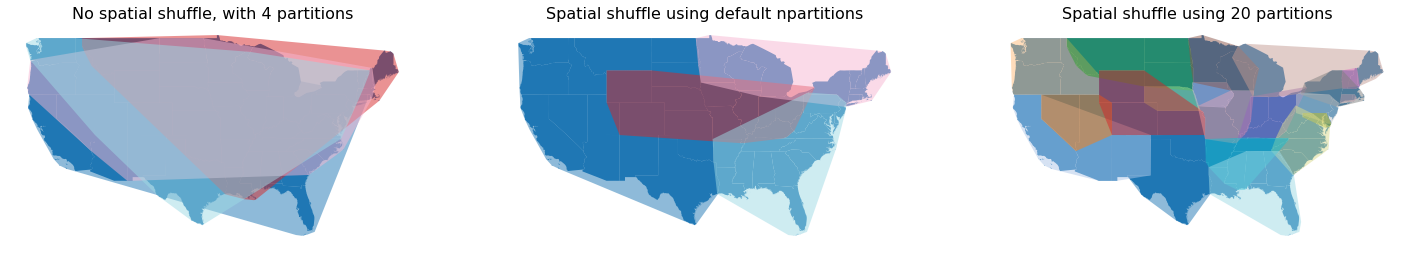

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(25,12))
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    us_cont.plot(ax=ax)

d_gdf.spatial_partitions.plot(ax=ax1, cmap="tab20", alpha=0.5)
hilbert.spatial_partitions.plot(ax=ax2, cmap="tab20", alpha=0.5)
hilbert20.spatial_partitions.plot(ax=ax3, cmap="tab20", alpha=0.5)

[axi.set_axis_off() for axi in axes.ravel()]

ax1.set_title("No spatial shuffle, with 4 partitions", size=16)
ax2.set_title("Spatial shuffle using default npartitions", size=16)
ax3.set_title("Spatial shuffle using 20 partitions", size=16)

plt.show()

## Level of precision
The `level` parameter represents the precision of each partitioning method.
This defaults to 16 for both the Hilbert and Morton distance.
However, the Geohash method does not use this parameter and defaults to the integer representation.
We have found there are no significant penalties in selecting the maximum precision.

## Summary
Dask offers some further guidance on partitioning Pandas DataFrames, which include;
1. If your DataFrame fits easily into memory, then [Geo]Pandas can often be faster and easier to use than Dask[-GeoPandas] - so we always recommend trying GeoPandas first.
2. If you are running into memory and/or performance issues with [Geo]Pandas, then the number of partitions should fit comfortably in memory (each smaller than a gigabyte) - so if you are handling a 10GB dataset, then perhaps try using 10 partitions. 
3. If you are performing many tasks, where you increase/decrease the size of each DataFrame, it's useful to reconsider how many partitions you need. This may mean repartitioning your DataFrame again or using [Geo]Pandas.
4. It may be that only a single component of your workflow does not fit into memory and we recommend using [Geo]Pandas once this single component has been computed.

Dask offers [further guidance](https://docs.dask.org/en/latest/best-practices.html) on when/how to use partitioning.